In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris as iris
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import tree
from random import sample

Wczytanie danych i podział PU:PT = 80:20

In [22]:
ir=iris()
data = pd.DataFrame(data= np.c_[ir['data'], ir['target']],
                     columns= ir['feature_names'] + ['target'])
indexes_0 = sample(range(50), 50)
indexes_1 = sample(range(50,100), 50)
indexes_2 = sample(range(100,150), 50)

PU = data.loc[indexes_0[0:40]].append(data.loc[indexes_1[0:40]]).append(data.loc[indexes_2[0:40]]).sample(frac=1)
PT = data.loc[indexes_0[40:50]].append(data.loc[indexes_1[40:50]]).append(data.loc[indexes_2[40:50]]).sample(frac=1)
PU.target = PU.target.astype(int)
PT.target = PT.target.astype(int)

Wyznaczenie parametru alpha dla optymalnego drzewa decyzyjnego.

In [23]:
tree_classifier = tree.DecisionTreeClassifier()
d = tree_classifier.cost_complexity_pruning_path(PU[PU.columns[:4]],PU["target"])
ccp_alphas = d.ccp_alphas.reshape(len(d.ccp_alphas),1)
accuracy = np.array([])
for i in range(len(ccp_alphas)):
    pruned_tree_classifier = tree.DecisionTreeClassifier(ccp_alpha=ccp_alphas[i])  
    accuracy = np.append(accuracy, cross_val_score(pruned_tree_classifier, PU[PU.columns[:4]], PU["target"], cv = 5).mean())

Wyznaczenie liczby fałszywych predykcji dla zespołów M klasyfikatorów LDA i drzew decyzyjnych. M = [1,2,5,10,20,50]

In [24]:
M_class = np.array([1,2,5,10,20,50])
false_pred_LDA = np.zeros(6)
false_pred_tree = np.zeros(6)
for i in range(len(M_class)):
    #klasyfikacja PT, wyznaczenie macierzy pomyłek i obliczenie liczby fałszywych predykcji dla zespołu LDA
    predictions = BaggingClassifier(LDA(), n_estimators = M_class[i]).fit(PU[PU.columns[:4]], PU["target"]).predict(PT[PT.columns[:4]])
    cm = confusion_matrix(PT["target"],predictions)
    false_pred_LDA[i] = sum(sum(cm))-sum(np.diag(cm))
    #klasyfikacja PT, wyznaczenie macierzy pomyłek i obliczenie liczby fałszywych predykcji dla zespołu drzew decyzyjnych
    predictions = BaggingClassifier(tree.DecisionTreeClassifier(ccp_alpha = ccp_alphas[np.argmax(accuracy)]), n_estimators = M_class[i]).fit(PU[PU.columns[:4]], PU["target"]).predict(PT[PT.columns[:4]])
    cm = confusion_matrix(PT["target"],predictions)
    false_pred_tree[i] = sum(sum(cm))-sum(np.diag(cm))

Wykreślenie liczby fałszywych predykcji dla zespołów M klasyfikatorów LDA i drzew decyzyjnych.

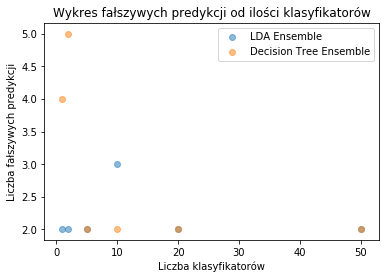

In [27]:
fig, ax = plt.subplots()
ax.scatter(M_class, false_pred_LDA, label = "LDA Ensemble", alpha = 0.5)
ax.scatter(M_class, false_pred_tree, label = "Decision Tree Ensemble", alpha = 0.5)
ax.set_title("Wykres fałszywych predykcji od ilości klasyfikatorów")
ax.set_xlabel("Liczba klasyfikatorów")
ax.set_ylabel("Liczba fałszywych predykcji")
ax.legend()
plt.show(fig)